Theoretical orbit response to kick $\theta$:

$$C_{ij} = \theta_i \frac{ \sqrt{\beta_i \beta_j}}{2 \sin{\pi Q}} \cos(  2 \pi | \mu_i - \mu_j| - \pi Q) + \frac{\eta_i \eta_j}{\left( \alpha_C - \frac{1}{\gamma^2}\right) C}$$

LOCO needs to compute

$$M_x = \frac{\partial^2 x_i}{\partial \theta_j \partial k_{1,m}}$$
$$M_y = \frac{\partial^2 y_i}{\partial \theta_j \partial k_{1,m}}$$

where $\{\theta_j\}$ are orbit correctors hor. and vert.

and

$\{ k_{1,m}\}$ are quadrupole normal and skew used for correction, as many as there are power supplies

input:
perturb.param or script generating same
...

In [1]:
print(f"LOCO, AT version")
from at import *
from pylab import *
from AT_ORM import *
from at.load import load_mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from random import random

LOCO, AT version


In [2]:
# The lattice

from lattice2 import *
#ring = [B1H, CXY01, DD, BPM, QF,SF, DD, B1H, B1H, CXY02, DD, BPM, QD, DD, B1H, m0]
ring=at.Lattice(ring, energy=1)
ring.radiation_off()

preparing twiss ..
Tunes=[0.21791539 0.11800144]
Chrom=[-0.13298722 -0.09636113]


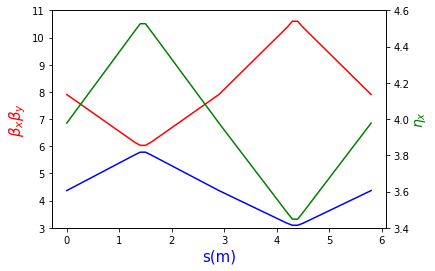

In [3]:
elements_indexes = get_refpts(ring, elements.Monitor)
twiss = getOptics(ring, '*', 'beta', 'False')

In [4]:
ring

Lattice([Dipole('B1H', 1.3, 0.3141592653589793, 0.0), Corrector('CXY', 0.0, array([0., 0.])), Drift('DD', 0.1), Monitor('BPM'), Quadrupole('QF', 0.1, 1.7), Drift('DD', 0.1), Dipole('B1H', 1.3, 0.3141592653589793, 0.0), Dipole('B1H', 1.3, 0.3141592653589793, 0.0), Corrector('CXY', 0.0, array([0., 0.])), Drift('DD', 0.1), Monitor('BPM'), Quadrupole('QD', 0.1, -2.1), Drift('DD', 0.1), Dipole('B1H', 1.3, 0.3141592653589793, 0.0), Marker('M0')], name='', energy=1, periodicity=1)

(2, 2)


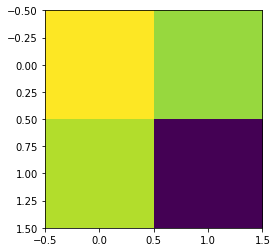

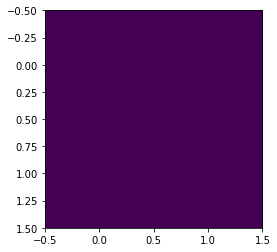

Cyy [[ 7.87874404 11.13182835]
 [10.92205486 13.5424808 ]]
Cyx [[0. 0.]
 [0. 0.]]


In [5]:
Cxx, Cxy= ORM_x(1.e-4, ring)
Cyy, Cyx= ORM_y(1.e-4, ring)

print(shape(Cxx))

plt.figure()
imshow(Cxx)
plt.show()

plt.figure()
imshow(Cyx)
plt.show()

print('Cyy',Cyy)
print('Cyx',Cyx)

In [6]:
Cyx

array([[0., 0.],
       [0., 0.]])

In [6]:
quads_info = quad_info(ring)

Done...


In [7]:
quad_dict,quad_vals = getQuadFamilies(quads_info)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],0])
print(quad_vals[quads[iq],0])
eocc_a, vals = getQuadFamilies(quads_info)
print(eocc_a)
print(quad_vals[quads[iq],0])

Quadrupoles:['QF', 'QD']
QD 0
-2.1
-2.1
{'QF': 0, 'QD': 0}
-2.1


In [8]:
def computeOpticsD(ring, qname, i, dk):

    bpm_indexes = get_refpts(ring, elements.Monitor)
    quad_indexes = get_refpts(ring, qname)

    #print(ring[quad_indexes[i]].K)
    ring[quad_indexes[i]].K =  quad_vals[qname,i] + dk

    qxx, qxy= ORM_x(0.0001, ring)
    qyy, qyx= ORM_y(0.0001, ring)

    ring[quad_indexes[i]].K = quad_vals[qname,i]
    print(ring[quad_indexes[i]].K)
    #print('Done')

    return  qxx, qxy, qyy, qyx

In [9]:
%%time
# sequential version, this takes long:
# optimize with parallelization and separate function
# prepare

dk = 0.0001
qxx = []
qxy =[]
qyy = []
qyx =[]
quad_names = quads
for qname in quad_names:
    print('generating response to {}, n={}'.format(qname, quad_dict[qname]))
    nq = quad_dict[qname]+1
    for i in range(0,nq):
       Qxx, Qxy, Qyy, Qyx = computeOpticsD(ring, qname,i, dk)
       qxx.append(Qxx)
       qxy.append(Qxy)
       qyy.append(Qyy)
       qyx.append(Qyx)

generating response to QF, n=0
1.7
generating response to QD, n=0
-2.1
Wall time: 29.9 ms


In [10]:
from loco import getTheorOrm, getOrm
from pylab import *

C0x = Cxx
C0y = Cyy
C0xy = Cxy
C0yx = Cyx

dk = 0.0001
dCx = []
dCy = []
dCxy = []
dCyx = []
quad_names = quads
for qname in quad_names:
    nquad = quad_dict[qname]
    print('loading response to:',qname)
    for i in range(0,nquad+1):

        C1x = qxx[i]
        C1y = qyy[i]
        C1xy = qxy[i]
        C1yx = qyx[i]

        dCx.append( (C1x-C0x)  / dk)
        dCy.append( (C1y-C0y) /dk)
        dCxy.append( (C1xy-C0xy)/ dk)
        dCyx.append( (C1yx-C0yx)/ dk)

loading response to: QF
loading response to: QD


In [11]:
len(dCx)
dCx[1]

array([[-1.28266668, -1.20259477],
       [-1.2085438 , -1.13311794]])

In [13]:
## simulate_errors

In [12]:
errorQF = 72.e-3 #0.01
errorQD = 52.e-5 #0.01
#tiltQF = 0.0003
#tiltQD = 0.0003

quads_info_error = simulateError(ring,errorQF,errorQD)

simulating perturbed machine...
Done...


preparing twiss ..
Tunes=[0.22149791 0.11424229]
Chrom=[-0.13585502 -0.09677687]


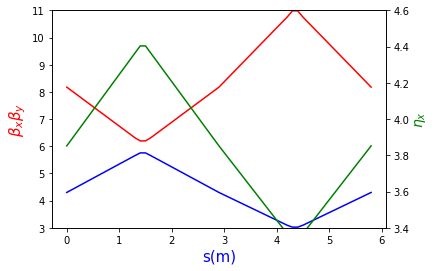

In [13]:
twiss_error = getOptics(ring, '*', 'beta', 'True')

In [16]:
#Cell2

(2, 2)


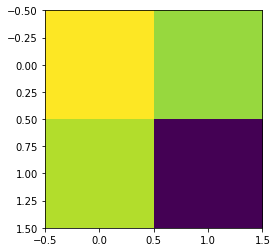

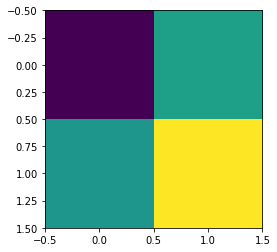

In [14]:
# ORM Cx, Cy

Cxx_err, Cxy_err= ORM_x_error(1.e-4, ring)
Cyy_err, Cyx_err= ORM_y_error(1.e-4, ring)

print(shape(Cxx_err))

plt.figure()
imshow(Cxx)
plt.show()

plt.figure()
imshow(Cyy_err)
plt.show()

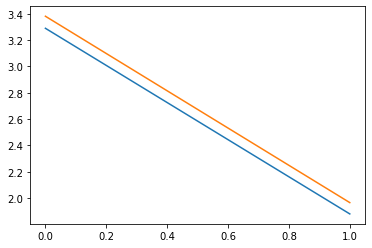

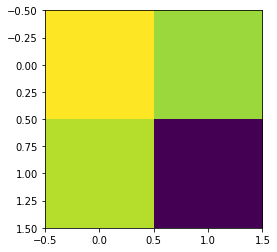

In [15]:
plt.plot(Cxx_err[1])
plt.plot((Cxx[1]))
plt.show()
plt.imshow(Cxx_err)
plt.show()

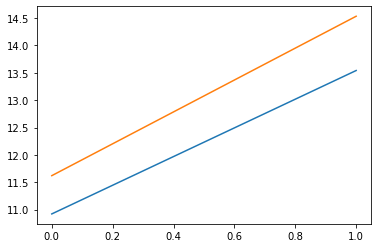

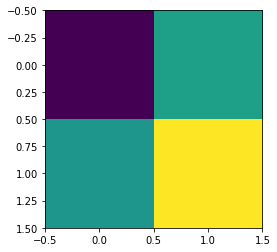

In [16]:
plt.plot(Cyy[1])
plt.plot((Cyy_err[1]))
plt.show()
plt.imshow(Cyy_err)

In [20]:
Cxx

array([[3.56230036, 3.31692879],
       [3.38044661, 1.96613616]])

In [21]:
print(np.max(Cyy_err-Cyy))

-0.27299447178862657


In [22]:
#Cell4

In [17]:
#A, B = build_matrix(ormx, ormy, C0x, C0x, C0x, dCx, dCy, dCxy, Cyx, ormx, ormy)


Nk = len(dCx) #number of free parameters (number of quads or g_k)
Nm = 40 # number of measurements (iteration) ######### #######
print('NK:', Nk)
print('Nm:', Nm)

Ax = np.zeros([Nk,Nk])
Ay = np.zeros([Nk,Nk])
Axy = np.zeros([Nk,Nk])
Ayx = np.zeros([Nk,Nk])

A = np.zeros([4*Nk,Nk]) # (160, 40) ###########


NK: 2
Nm: 40


In [18]:
Bx = np.zeros([Nk,1])
By = np.zeros([Nk,1])
Bxy = np.zeros([Nk,1])
Byx = np.zeros([Nk,1])

B = np.zeros([4*Nk,1])


In [19]:
Dx = (Cxx_err[0:Nm,:] - C0x[0:Nm,:]) ### dk ?
Dy = (Cyy_err[0:Nm,:] - C0y[0:Nm,:])
Dxy = (Cxy_err[0:Nm,:] - C0xy[0:Nm,:])
Dyx = (Cyx_err[0:Nm,:] - C0yx[0:Nm,:])

In [26]:
Dx.shape

(2, 2)

In [20]:
for i in range(Nk): ## i represents each quad
    #print('done A:', 100.* i ,'%')
    for j in range(Nk):
        Ax[i,j] = np.sum(np.dot(dCx[i],dCx[j].T) )
        Ay[i,j] = np.sum(np.dot(dCy[i],dCy[j].T) )
        Axy[i,j] = np.sum(np.dot(dCxy[i],dCxy[j].T) )
        Ayx[i,j] = np.sum(np.dot(dCyx[i],dCyx[j].T) )
    A[i,:] = Ax[i,:]
    A[i+Nk,:] = Ay[i,:]
    A[i+2*Nk,:] = Axy[i,:]
    A[i+3*Nk,:] = Ayx[i,:]

In [21]:
np.sum(np.dot(dCx[1],dCx[1].T))

11.661683460701388

In [29]:
B.shape

(8, 1)

In [22]:
for i in range(Nk):
    Bx[i] = np.sum( np.dot(dCx[i], Dx.T) )
    By[i] = np.sum( np.dot(dCy[i], Dy.T) )
    Bxy[i] = np.sum( np.dot(dCxy[i], Dxy.T) )
    Byx[i] = np.sum( np.dot(dCyx[i], Dyx.T) )
    B[i] = Bx[i]
    B[i+Nk] = By[i]
    B[i+2*Nk] = Bxy[i]
    B[i+3*Nk] = Byx[i]

number of singular values 2
A(8, 2) B(8, 1) U(8, 8) smat(8, 2) v(2, 2)


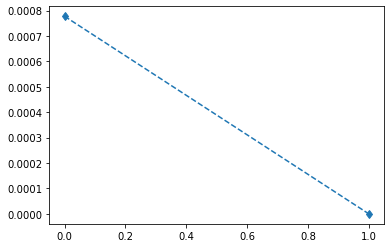

In [23]:
u,s,v=np.linalg.svd(A,  full_matrices=True)

smat = 0.0 * A
si = s**-1
n_sv = 1
si[n_sv:] *= 0.0

print("number of singular values {}".format(len(si)))
smat[:Nk,:Nk] = np.diag(si)


print('A'+str(A.shape), 'B'+str(B.shape),'U'+str(u.shape), 'smat'+str(smat.shape), 'v'+str(v.shape))


plt.plot(si,'d--')
plt.show()

In [32]:
si

array([0.00077765, 0.        ])

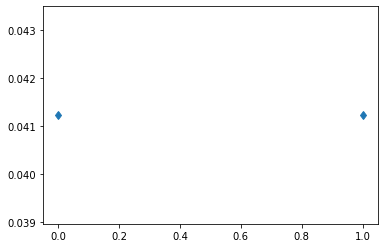

In [24]:
Ai=np.dot(v.transpose(),np.dot(smat.transpose(),u.transpose()))

###
r = ( np.dot(Ai,B)).reshape(-1)
plot(r,'d')
plt.show()

In [34]:
Ai.shape

(2, 8)

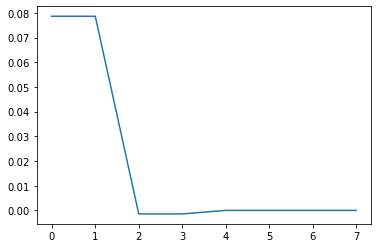

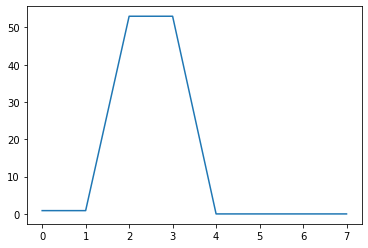

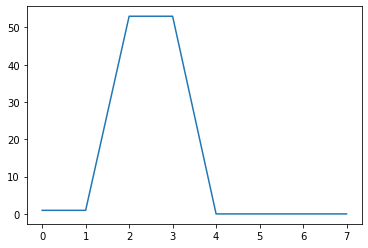

In [25]:
# error
e = np.dot(A,r).reshape(-1) - B.reshape(-1)
plt.plot(e)
plt.show()
plt.plot(B)
plt.show()
plt.plot(np.dot(A,r).reshape(-1))
plt.show()


In [36]:
np.dot(A,r).reshape(-1)

array([ -0.40596527,  -0.40596527, -22.37901161, -22.37901161,
         0.        ,   0.        ,   0.        ,   0.        ])

In [37]:
B

array([[  0.02778135],
       [  0.02778135],
       [-22.38687996],
       [-22.38687996],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ]])

In [26]:
quad_dict,quad_vals = getQuadFamilies(quads_info_error)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],1])
print(quad_vals[quads[iq],1])
eocc_a, vals = getQuadFamilies(quads_info_error)
print(eocc_a)
print(quad_vals[quads[iq],1])

Quadrupoles:['QF', 'QD']
QD 1
-2.1002635314614824
-2.1002635314614824
{'QF': 1, 'QD': 1}
-2.1002635314614824


In [27]:
# check correction...


n_list = len(quads_info_error.s_pos)
print(n_list)

quad_names = quad_names
iq = 0
frac = 1.0
cor_dict = {}
for qname in quad_names:
    nquad = quad_dict[qname]
    #print(qname, quad_dict[qname])
    for i in range(0, nquad):
        cor_dict[qname, i+1] = -r[iq]*frac
        iq += 1

2


In [40]:
nquad

1

In [28]:
DK = []
for idx in range(n_list):
   qname_ = quads_info.elements_name[idx]  # ElementName

   if qname_ == 'QF':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QF',occ]
      DK.append(dk)

   if qname_ == 'QD':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QD',occ]
      DK.append(dk)

In [42]:
r

array([-0.01740595, -0.01740595])

In [43]:
DK

[0.017405946000589815, 0.017405946000589822]

In [29]:
QF_indexes = get_refpts(ring, 'QF')
QD_indexes = get_refpts(ring, 'QD')
quads_indexes = get_refpts(ring, elements.Quadrupole)

In [30]:

print(ring[quads_indexes[1]].K)
ring[quads_indexes[0]].K += DK[0]
ring[quads_indexes[1]].K += DK[1]
print(ring[quads_indexes[1]].K)



-2.1002635314614824
-2.141487689374197


In [31]:
quads_info_error.Quad_strength

0    1.777957
1   -2.100264
Name: Quad_strength, dtype: float64

preparing twiss ..
Tunes=[0.21860096 0.11975864]
Chrom=[-0.13432247 -0.09839012]


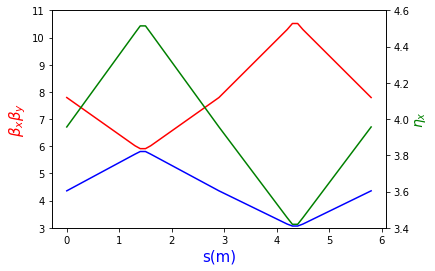

In [32]:
twiss_corrected = getOptics(ring, '*', 'beta', 'True')

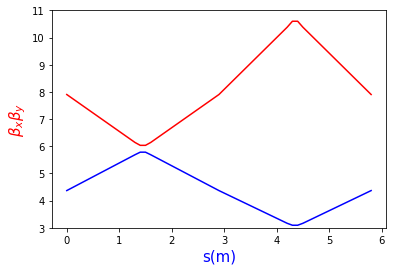

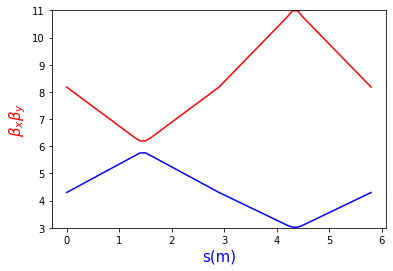

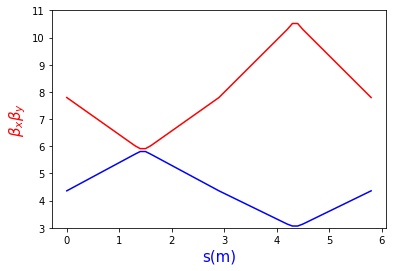

In [33]:

fig, ax = plt.subplots()
ax.plot(twiss.s_pos, twiss.betax, color="blue")
ax.plot(twiss.s_pos, twiss.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)
plt.show()



fig, ax = plt.subplots()
ax.plot(twiss_error.s_pos, twiss_error.betax, color="blue")
ax.plot(twiss_error.s_pos, twiss_error.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)
plt.show()


fig, ax = plt.subplots()
ax.plot(twiss_corrected.s_pos, twiss_corrected.betax, color="blue")
ax.plot(twiss_corrected.s_pos, twiss_corrected.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)
plt.show()


In [34]:
twiss_error

,s_pos,closed_orbitx,closed_orbity,betax,betay,elements_strength,elements_name,occ,elements_type
0,0.0,0.0,0.0,4.300643,8.175102,0.000000,B1H,1,0
1,1.3,0.0,0.0,5.656898,6.311072,0.000000,CXY,1,0
2,1.3,0.0,0.0,5.656898,6.311072,0.000000,DD,1,0
3,1.4,0.0,0.0,5.755469,6.197314,0.000000,BPM,1,0
4,1.4,0.0,0.0,5.755469,6.197314,1.777957,QF,1,elements.Quadrupole
5,1.5,0.0,0.0,5.755469,6.197314,0.000000,DD,2,0
6,1.6,0.0,0.0,5.656898,6.311072,0.000000,B1H,2,0
7,2.9,0.0,0.0,4.300643,8.175102,0.000000,B1H,3,0
8,4.2,0.0,0.0,3.094445,10.754472,0.000000,CXY,2,0
9,4.2,0.0,0.0,3.094445,10.754472,0.000000,DD,3,0


In [50]:
twiss_corrected

,s_pos,closed_orbitx,closed_orbity,betax,betay,elements_strength,elements_name,occ,elements_type
0,0.0,0.0,0.0,4.343515,7.943215,0.000000,B1H,1,0
1,1.3,0.0,0.0,5.686042,6.144275,0.000000,CXY,1,0
2,1.3,0.0,0.0,5.686042,6.144275,0.000000,DD,1,0
3,1.4,0.0,0.0,5.782887,6.035665,0.000000,BPM,1,0
4,1.4,0.0,0.0,5.782887,6.035665,1.739214,QF,1,elements.Quadrupole
5,1.5,0.0,0.0,5.782887,6.035665,0.000000,DD,2,0
6,1.6,0.0,0.0,5.686042,6.144275,0.000000,B1H,2,0
7,2.9,0.0,0.0,4.343515,7.943215,0.000000,B1H,3,0
8,4.2,0.0,0.0,3.131915,10.460902,0.000000,CXY,2,0
9,4.2,0.0,0.0,3.131915,10.460902,0.000000,DD,3,0
